# Visualising Score & Schedules of the Diffusion Model


In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "jax"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import timeit

import keras
import bayesflow as bf
from tqdm import tqdm

from scipy.stats import norm
sech = lambda x: 1 / np.cosh(x)

INFO:2025-09-09 11:28:16,376:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:bayesflow:Using backend 'jax'


## Simulator<a class="anchor" id="simulator"></a>

In [2]:
def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [3]:
simulator = bf.make_simulator([theta_prior, forward_model])

In [4]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
)

# Training

In [5]:
num_training_batches = 512
num_validation_sets = 300
batch_size = 64
epochs = 100

In [6]:
training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

In [7]:
from bayesflow.networks.diffusion_model import EDMNoiseSchedule

In [8]:
# import math
# from typing import Literal
#
# from keras import ops
#
# from bayesflow.types import Tensor
# from bayesflow.utils.serialization import deserialize, serializable
# from bayesflow.networks.diffusion_model.schedules import NoiseSchedule
#
# # disable module check, use potential module after moving from experimental
# @serializable("bayesflow.networks", disable_module_check=True)
# class TrigFlowNoiseSchedule(NoiseSchedule):
#     """TrigFlow noise schedule for diffusion models. This schedule is based on [1].
#
#     A continuous-time noise schedule that uses trigonometric functions to define the log signal-to-noise.
#
#     [1] Lu, C., & Song, Y. (2025). Simplifying, Stabilizing and Scaling Continuous-Time Consistency Models
#     """
#
#     def __init__(
#         self,
#         target_std: float = 1.0,
#         weighting: Literal["sigmoid", "likelihood_weighting"] = "sigmoid",
#     ):
#         """
#         Initialize the cosine noise schedule.
#
#         Parameters
#         ----------
#         target_std : float, optional
#             The target standard deviation of the noise at the end of the diffusion process. Default is
#             1.0, should be the same as the standard deviation of the target at t=0.
#         weighting : Literal["sigmoid", "likelihood_weighting"], optional
#             The type of weighting function to use for the noise schedule. Default is "sigmoid".
#         """
#         super().__init__(name="trig_flow_noise_schedule", variance_type="preserving", weighting=weighting)
#         self.target_std = target_std
#         self._weighting = weighting
#
#         self._t_min = 0 + 1e-5
#         self._t_max = math.pi / 2
#
#         self.log_snr_max = self.get_log_snr(ops.convert_to_tensor(0.0), training=False)
#         self.log_snr_min = self.get_log_snr(ops.convert_to_tensor(1.0), training=False)
#
#     def _truncated_t(self, t: Tensor) -> Tensor:
#         return self._t_min + (self._t_max - self._t_min) * t
#
#     def get_alpha_sigma(self, log_snr_t: Tensor) -> tuple[Tensor, Tensor]:
#         """Get alpha and sigma for a given log signal-to-noise ratio (lambda)."""
#         t = self.get_t_from_log_snr(log_snr_t=log_snr_t, training=False)
#
#         alpha = ops.cos(t)
#         sigma = ops.sin(t) * self.target_std
#         return alpha, sigma
#
#     def get_log_snr(self, t: Tensor | float, training: bool) -> Tensor:
#         """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
#         t_trunc = self._truncated_t(t)
#         return ops.log(ops.cos(t_trunc) ** 2 / (ops.sin(t_trunc) ** 2 * self.target_std))
#
#     def get_t_from_log_snr(self, log_snr_t: Tensor | float, training: bool) -> Tensor:
#         """Get the diffusion time (t) from the log signal-to-noise ratio (lambda)."""
#         return ops.arcsin(1 / ops.sqrt(1 + self.target_std * ops.exp(log_snr_t)))
#
#     def derivative_log_snr(self, log_snr_t: Tensor, training: bool) -> Tensor:
#         """Compute d/dt log(1 + e^(-snr(t))), which is used for the reverse SDE."""
#         t = self.get_t_from_log_snr(log_snr_t=log_snr_t, training=training)
#
#         # Compute the truncated time t_trunc
#         t_trunc = self._truncated_t(t)
#         dsnr_dx = -2 / (ops.sin(t_trunc) * ops.cos(t_trunc))
#
#         # Using the chain rule on f(t) = log(1 + e^(-snr(t))):
#         # f'(t) = - (e^{-snr(t)} / (1 + e^{-snr(t)})) * dsnr_dt
#         dsnr_dt = dsnr_dx * (self._t_max - self._t_min)
#         factor = ops.exp(-log_snr_t) / (1 + ops.exp(-log_snr_t))
#         return -factor * dsnr_dt
#
#     # def get_weights_for_snr(self, log_snr_t: Tensor) -> Tensor:
#     #     alpha, sigma = self.get_alpha_sigma(log_snr_t)
#     #     velocity_weighting = 1 / (alpha** 2 * (ops.exp(-log_snr_t) + 1)**2)
#     #
#     #     additional_weights = super().get_weights_for_snr(log_snr_t=log_snr_t)
#     #     return velocity_weighting * additional_weights
#
#     def get_config(self):
#         config = {
#             "target_std": self.target_std,
#             "weighting": self._weighting,
#         }
#         return config
#
#     @classmethod
#     def from_config(cls, config, custom_objects=None):
#         return cls(**deserialize(config, custom_objects=custom_objects))


In [9]:
workflows = {}

for noise_schedule in ['cosine', 'edm', 'edm_ve']:
    diffusion_model_workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        inference_network = bf.networks.DiffusionModel(
            noise_schedule=noise_schedule if noise_schedule != 'edm_ve' else EDMNoiseSchedule(variance_type='exploding'),
            prediction_type='velocity' if noise_schedule == 'cosine' else 'F',
        ),
    )
    workflows['diffusion_model_'+noise_schedule] = diffusion_model_workflow

for ot in [False, True]:
    name = "flow_matching_ot" if ot else "flow_matching"
    for time_sampling_alpha in [0, -0.6]:
        if time_sampling_alpha != 0:
            continue
            name += '_pl'
        flow_matching_workflow = bf.BasicWorkflow(
            simulator=simulator,
            adapter=adapter,
            inference_network = bf.networks.FlowMatching(
                use_optimal_transport=ot,
                time_power_law_alpha=-0.6
            ),
        )
        workflows[name] = flow_matching_workflow

In [10]:
for name, workflow in workflows.items():
    if os.path.exists('models/two_moons_'+name+'.keras'):
        print(f"Loading {name} from disk")
        workflow.fit_offline(  # otherwise some building steps are not executed
            training_data,
            epochs=1,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=0
        )
        workflow.approximator = keras.saving.load_model('models/two_moons_'+name+'.keras')
        continue

    print(f"Training {name}...")
    start = timeit.default_timer()
    workflow.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=0
    )
    workflow.approximator.save('models/two_moons_'+name+'.keras')
    end = timeit.default_timer()
    print(f"Trained {name} in {end - start:.2f} seconds")

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Training diffusion_model_cosine...


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Trained diffusion_model_cosine in 162.66 seconds
Training diffusion_model_edm...


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Trained diffusion_model_edm in 166.26 seconds
Training diffusion_model_edm_ve...


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Trained diffusion_model_edm_ve in 165.17 seconds
Training flow_matching...


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Trained flow_matching in 212.41 seconds
Training flow_matching_ot...


Trained flow_matching_ot in 415.63 seconds


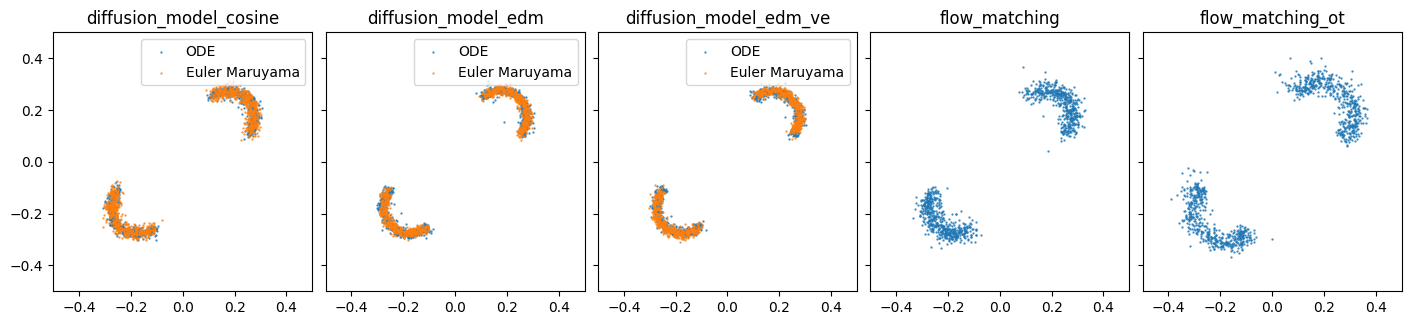

In [31]:
fig, ax = plt.subplots(ncols=len(workflows), figsize=(14, 5), layout='constrained', sharey=True, sharex=True)
if len(workflows) == 1:
    ax = [ax]
for i, (name, workflow) in enumerate(workflows.items()):
    samples = workflow.sample(num_samples=1000, conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
    ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="ODE")

    if name.split('_')[0] == 'diffusion':
        samples = workflow.sample(num_samples=1000, method="euler_maruyama",
                                  conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
        ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="Euler Maruyama")
        ax[i].legend(loc="upper right")

    ax[i].set_title(name)
    ax[i].set_aspect('equal')
ax[-1].set_xlim([-0.5, 0.5])
ax[-1].set_ylim([-0.5, 0.5])
plt.show()

# Visualizing the Trajectory

In [12]:
def euler_backward_like(workflow, conditions, x0=None, steps=100, stochastic_solver=False):
    num_samples = 1  # not sure if the code would work with more, but not needed
    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, num_samples, *keras.ops.shape(inference_conditions)[2:])
    )

    if workflow.approximator.inference_network.name.split('_')[0] == 'flow':
        t_start, t_end = 0.0, 1.0
    elif workflow.approximator.inference_network.name.split('_')[0] == 'diffusion':
        t_start, t_end = 1.0, 0.0
    else:
        raise ValueError("Unknown inference network type")

    dt = (t_end - t_start) / steps  # negative if integrating toward 0
    if x0 is not None:
        x = x0
    else:
        # sample from the base distribution
        x = workflow.approximator.inference_network.base_distribution.sample((1, num_samples))
    t = float(t_start)

    traj = []
    vels = []
    for k in range(steps):
        traj.append(keras.ops.convert_to_numpy(x))
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
            if stochastic_solver:
                diff_curr = workflow.approximator.inference_network.diffusion_term(
                    xz=x, time=t, training=False
                )
                noise = keras.random.normal(keras.ops.shape(x), dtype=keras.ops.dtype(x)) * np.sqrt(np.abs(dt))
                x = x + diff_curr * noise

        x = x + dt * v_curr
        t = t + dt
        vels.append(keras.ops.convert_to_numpy(v_curr))

    traj = np.stack(traj, axis=0)      # shape [steps+1, batch, num_samples, dims]
    vels = np.stack(vels, axis=0)      # shape [steps,   batch, num_samples, dims]
    times = np.linspace(t_start, t_end, steps+1, dtype=np.float32)

    traj =  workflow.approximator.standardize_layers["inference_variables"](traj, forward=False)
    return traj, vels, times

In [13]:
x0 = workflows[list(workflows.keys())[0]].approximator.inference_network.base_distribution.sample((1, 1)) * 0
conditions = {"x":np.array([[0.0, 0.0]], dtype=np.float32)}

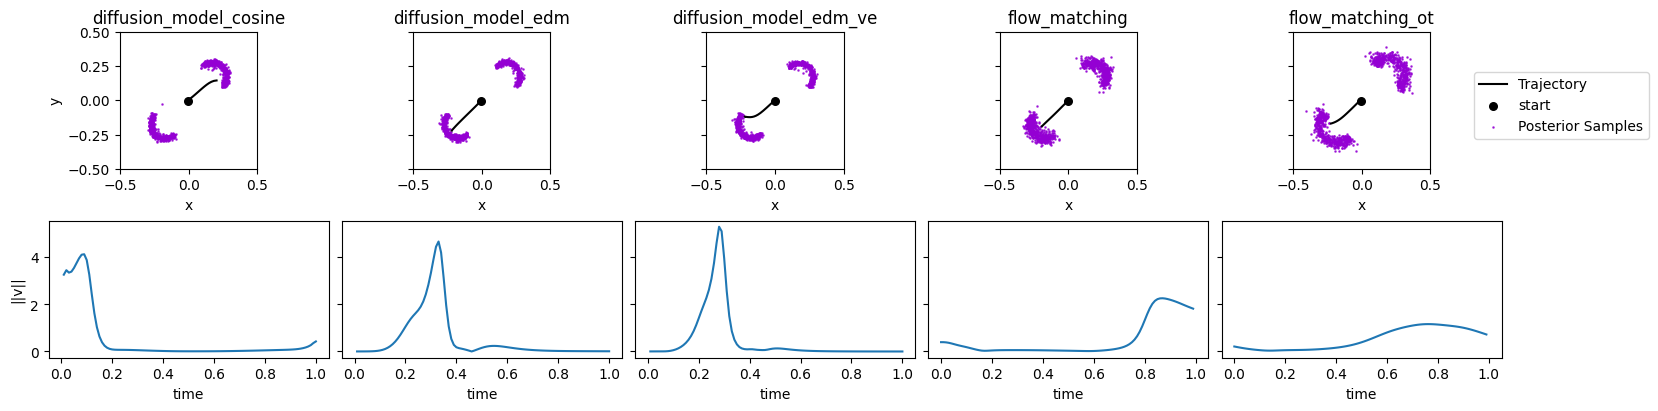

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=len(workflows), figsize=(3*len(workflows), 4),
                       layout='constrained', sharey='row', sharex='row')
for i, (name, workflow) in enumerate(workflows.items()):
    traj, vels, times = euler_backward_like(
        workflow, x0=x0, conditions=conditions, steps=100, stochastic_solver=False
    )
    traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
    vel_norm = np.linalg.norm(vels, axis=-1)
    ax[0, i].plot(traj[:, 0], traj[:, 1], color='black', label="Trajectory" if i == 0 else None)
    ax[0, i].scatter(traj[0, 0], traj[0, 1], s=30, marker='o', label='start' if i == 0 else None, color='black') # start
    #ax[0, i].scatter(traj[-1, 0], traj[-1, 1], s=30, marker='x', label='end' if i == 0 else None, color='black') # end

    samples = workflow.sample(num_samples=1000, conditions=conditions)
    ax[0, i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.75,
                     color='darkviolet', label="Posterior Samples" if i == 0 else None)

    ax[1, i].plot(times[:-1], vel_norm)
    #ax[1, i].set_title("Velocity norm over time")
    ax[1, i].set_xlabel("time")

    ax[0, i].set_title(name)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.1, 0.85))
ax[0, 0].set_ylabel("y")
ax[0, -1].set_xlim([-0.5, 0.5])
ax[0, -1].set_ylim([-0.5, 0.5])
ax[1, 0].set_ylabel("||v||")
plt.show()

In [15]:
def moving_average(x, w=10):
    # convolution with same length
    y = np.convolve(x, np.ones(w)/w, mode="same")
    # force first and last values equal to input edges
    y[0] = x[0]
    y[-1] = x[-1]
    return y

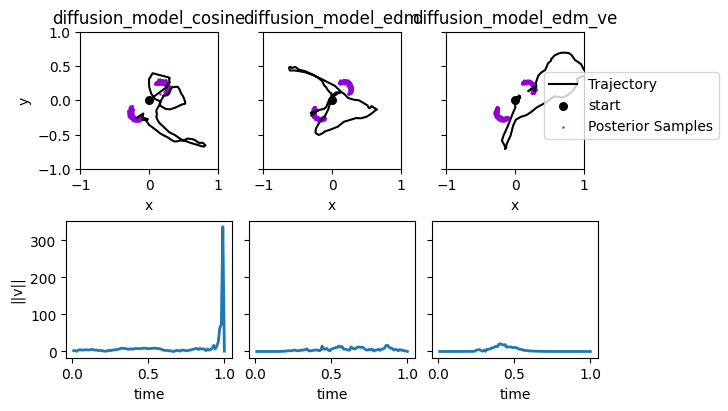

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(3*2, 4), layout='constrained', sharey='row', sharex='row')
for i, (name, workflow) in enumerate(workflows.items()):
    if name.split('_')[0] != 'diffusion':
        continue  # no stochastic solver

    traj, vels, times = euler_backward_like(
        workflow, x0=x0, conditions=conditions, steps=100, stochastic_solver=True
    )
    traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
    vel_norm = np.linalg.norm(vels, axis=-1)
    x_smooth = moving_average(traj[:,0])
    y_smooth = moving_average(traj[:,1])
    ax[0, i].plot(x_smooth, y_smooth, color='black', label="Trajectory" if i == 0 else None)
    ax[0, i].scatter(x_smooth[0], y_smooth[0], s=30, marker='o', label='start' if i == 0 else None, color='black')
    #ax[0, i].scatter(x_smooth[-1], y_smooth[-1], s=30, marker='x', label='end' if i == 0 else None, color='black')

    samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
    ax[0, i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.75,
                     color='darkviolet', label="Posterior Samples" if i == 0 else None)

    ax[1, i].plot(times[:-1], vel_norm, linewidth=2)
    #ax[1, i].set_title("Velocity norm over time")
    ax[1, i].set_xlabel("time")

    ax[0, i].set_title(name)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.2, 0.85))
ax[0, 0].set_ylabel("y")
ax[0, -1].set_xlim([-1, 1])
ax[0, -1].set_ylim([-1, 1])
ax[1, 0].set_ylabel("||v||")
plt.show()

In [17]:
n_trajectories = 20
colors = [
    "#0072B2",  # blue (EDM)
    "#E69F00",  # orange (Cosine)
    "#009E73",  # green (Flow Matching)
    "#D55E00",  # red (Flow Matching power law)
]

100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


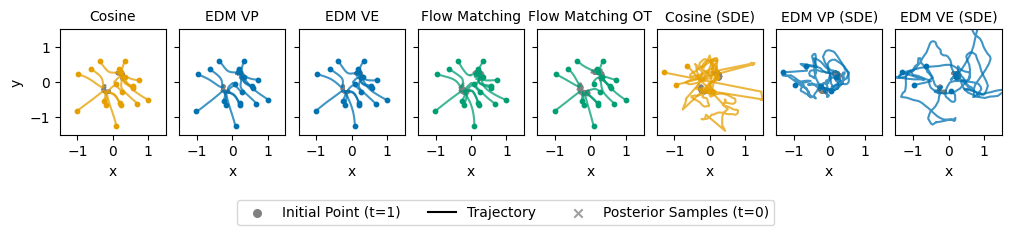

In [18]:
fig, ax = plt.subplots(ncols=len(workflows)+3, figsize=(10, 3),
                       layout='constrained', sharey='row', sharex='row')
for j in tqdm(range(n_trajectories)):
    x0_i = workflows[list(workflows.keys())[0]].approximator.inference_network.base_distribution.sample((1, 1))
    for i, (name, workflow) in enumerate(workflows.items()):
        if name.split('_')[0] == 'diffusion':
            if name.split('diffusion_model_')[1] =='edm':
                 ax[i].set_title('EDM VP')
                 _color = colors[0]
            elif name.split('diffusion_model_')[1] =='edm_ve':
                ax[i].set_title('EDM VE')
                _color = colors[0]
            else:
                ax[i].set_title(name.split('diffusion_model_')[1].title())
                _color = colors[1]
        else:
            if name == 'flow_matching_ot':
                ax[i].set_title('Flow Matching OT')
                _color = colors[2]
            else:
                ax[i].set_title('Flow Matching')
                _color = colors[2]

        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=100, stochastic_solver=False
        )
        traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
        ax[i].plot(traj[:, 0], traj[:, 1], color=_color, alpha=0.75,
                   label="Trajectory" if i == 0 and j == 0 else None)
        ax[i].scatter(traj[0, 0], traj[0, 1], s=10, marker='o',
                      label='start' if i == 0 and j == 0 else None, color=_color)

        if j == 0:
            samples = workflow.sample(num_samples=1000, conditions=conditions)
            ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.4,
                          color='gray', label="Posterior Samples" if i == 0 else None)
        ax[i].set_aspect('equal')
        ax[i].set_xlabel("x")

for j in tqdm(range(int(n_trajectories*0.25))):
    x0_i = workflows[list(workflows.keys())[0]].approximator.inference_network.base_distribution.sample((1, 1))
    new_i = 0
    for i, (name, workflow) in enumerate(workflows.items()):
        if name.split('_')[0] != 'diffusion':
            continue  # no stochastic solver
        if name.split('diffusion_model_')[1] =='edm':
             ax[len(workflows)+new_i].set_title('EDM VP' + ' (SDE)')
             _color = colors[0]
        elif name.split('diffusion_model_')[1] =='edm_ve':
            ax[len(workflows)+new_i].set_title('EDM VE' + ' (SDE)')
            _color = colors[0]
        else:
            ax[len(workflows)+new_i].set_title(name.split('diffusion_model_')[1].title() + ' (SDE)')
            _color = colors[1]

        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=100, stochastic_solver=True
        )
        traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
        x_smooth = moving_average(traj[:,0])
        y_smooth = moving_average(traj[:,1])
        ax[len(workflows)+new_i].plot(x_smooth, y_smooth, color=_color, alpha=0.75)
        ax[len(workflows)+new_i].scatter(x_smooth[0], y_smooth[0], s=10, marker='o', color=_color)

        if j == 0:
            samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
            ax[len(workflows)+new_i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.4,
                          color='gray')

        ax[len(workflows)+new_i].set_aspect('equal')
        ax[len(workflows)+new_i].set_xlabel("x")
        new_i += 1

handles = [
    plt.scatter([], [], color='gray', marker='o', s=30, label='Initial Point (t=1)'),
    Line2D([0], [0], color='black', label='Trajectory'),
    plt.scatter([], [], color='gray', marker='x', alpha=0.75, label='Posterior Samples (t=0)'),
]
fig.legend(handles=handles, bbox_to_anchor=(0.5, 0), loc='lower center', ncols=3)
ax[0].set_ylabel("y")
ax[-1].set_xlim([-1.5, 1.5])
ax[-1].set_ylim([-1.5, 1.5])
for a in ax:
    for item in ([a.title, a.xaxis.label, a.yaxis.label] + a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(10)
plt.savefig('trajectories.pdf', bbox_inches='tight')
plt.show()

100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


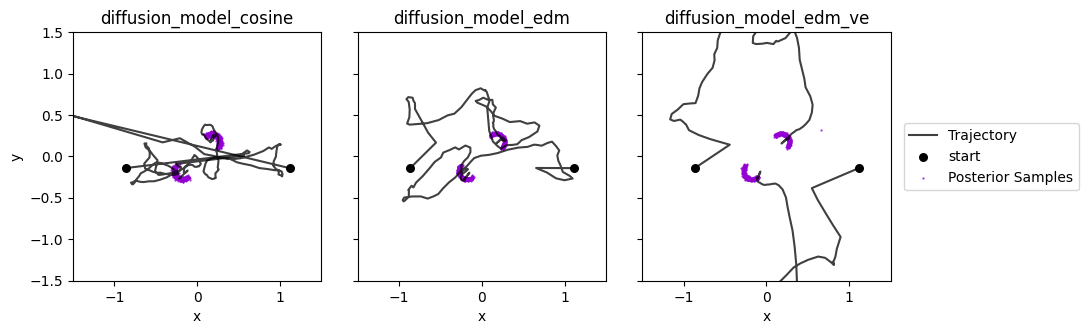

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(3*3, 4),
                       layout='constrained', sharey='row', sharex='row')
for j in tqdm(range(int(n_trajectories*0.1))):
    x0_i = workflows[list(workflows.keys())[0]].approximator.inference_network.base_distribution.sample((1, 1))
    for i, (name, workflow) in enumerate(workflows.items()):
        if name.split('_')[0] != 'diffusion':
            continue  # no stochastic solver

        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=100, stochastic_solver=True
        )
        traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
        x_smooth = moving_average(traj[:,0])
        y_smooth = moving_average(traj[:,1])
        ax[i].plot(x_smooth, y_smooth, color='black', alpha=0.75,
                   label="Trajectory" if i == 0 and j == 0 else None)
        ax[i].scatter(x_smooth[0], y_smooth[0], s=30, marker='o',
                      label='start' if i == 0 and j == 0 else None, color='black')
        #ax[i].scatter(x_smooth[-1], y_smooth[-1], s=30, marker='x',
        #              label='end' if i == 0 and j == 0 else None, color='black')

        if j == 0:
            samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
            ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.4,
                          color='darkviolet', label="Posterior Samples" if i == 0 else None)

        ax[i].set_title(name)
        ax[i].set_aspect('equal')
        ax[i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.2, 0.6))
ax[0].set_ylabel("y")
ax[-1].set_xlim([-1.5, 1.5])
ax[-1].set_ylim([-1.5, 1.5])
plt.show()

In [20]:
def velocity_field_plot(workflow, conditions, times, stochastic_solver=False,
                        traj=None, grid_limits=(-3,3), grid_points=20, name=None):
    # grid
    x = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    y = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    X, Y = np.meshgrid(x, y)
    grid = np.stack([X, Y], axis=-1)  # [grid_points, grid_points, 2]
    grid = grid.reshape(-1, 2)[None]  # [1, grid_points*grid_points, 2]

    grid_transf = workflow.approximator.standardize_layers["inference_variables"](grid.reshape(-1, 2), forward=False)
    grid_transf = keras.ops.convert_to_numpy(grid_transf)
    XY_transf = grid_transf.reshape(grid_points, grid_points, 2) # [G, G, 2]
    X_transf = XY_transf[..., 0]
    Y_transf = XY_transf[..., 1]

    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, grid_points*grid_points, *keras.ops.shape(inference_conditions)[2:])
    )

    fig, axes = plt.subplots(1, len(times), figsize=(5*len(times), 5), layout='constrained',
                             sharex=True, sharey=True, squeeze=False)

    for i, t in enumerate(times):
        # expand to shape [batch, num_samples, dim]
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
        v = keras.ops.convert_to_numpy(v)
        v = v[0, :, :2]  # [num_points, 2]

        U = v[:,0].reshape(grid_points, grid_points)
        V = v[:,1].reshape(grid_points, grid_points)

        ax = axes[0, i]
        ax.quiver(X_transf, Y_transf, U, -V, angles="xy", label="velocity field", alpha=0.5)
        if traj is not None:
            ax.plot(traj[:,0], traj[:,1], color="red", linewidth=2, label="trajectory")
            ax.scatter(traj[0,0], traj[0,1], color="green", s=60, label="start")
            ax.scatter(traj[-1,0], traj[-1,1], color="black", s=60, label="end")

        if name is not None:
            ax.set_title(f"{name} time={t:.2f}")
        else:
            ax.set_title(f"time={t:.2f}")
        ax.set_xlim((X_transf.min(), X_transf.max()))
        ax.set_ylim((Y_transf.min(), Y_transf.max()))
        ax.legend()
    plt.show()

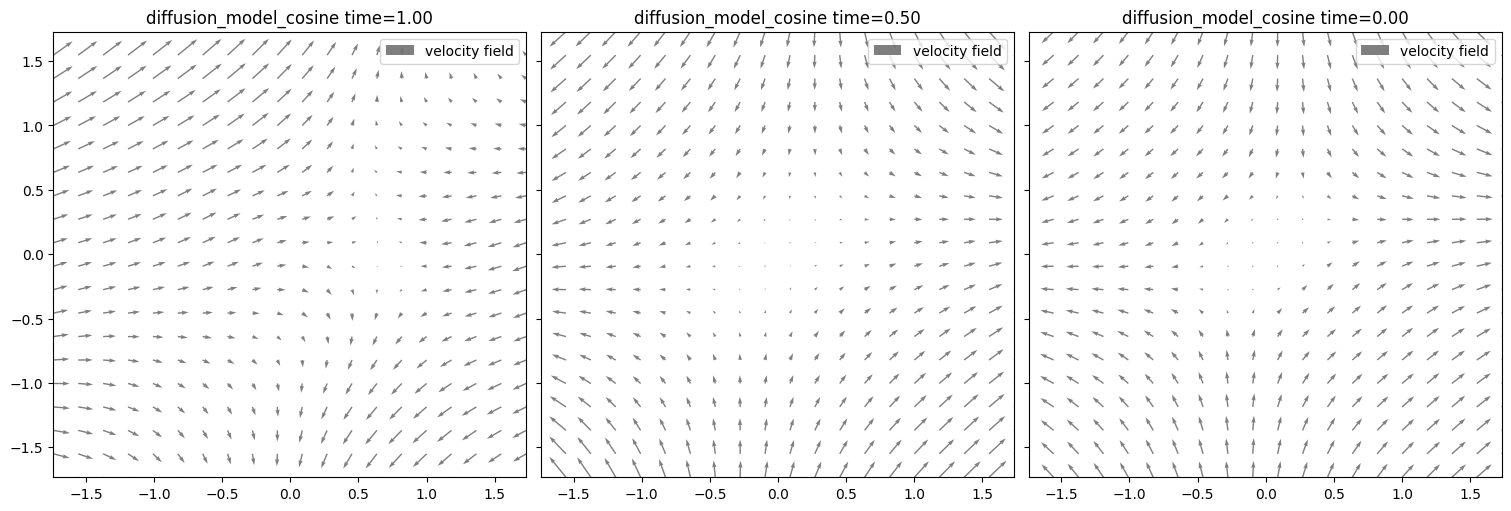

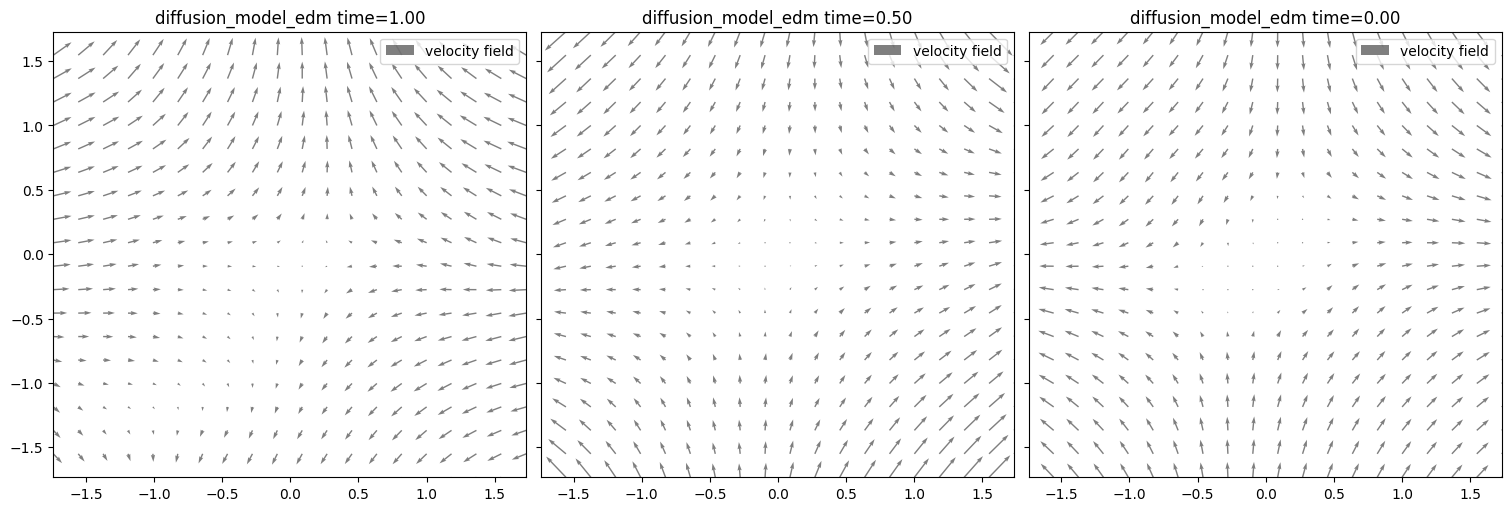

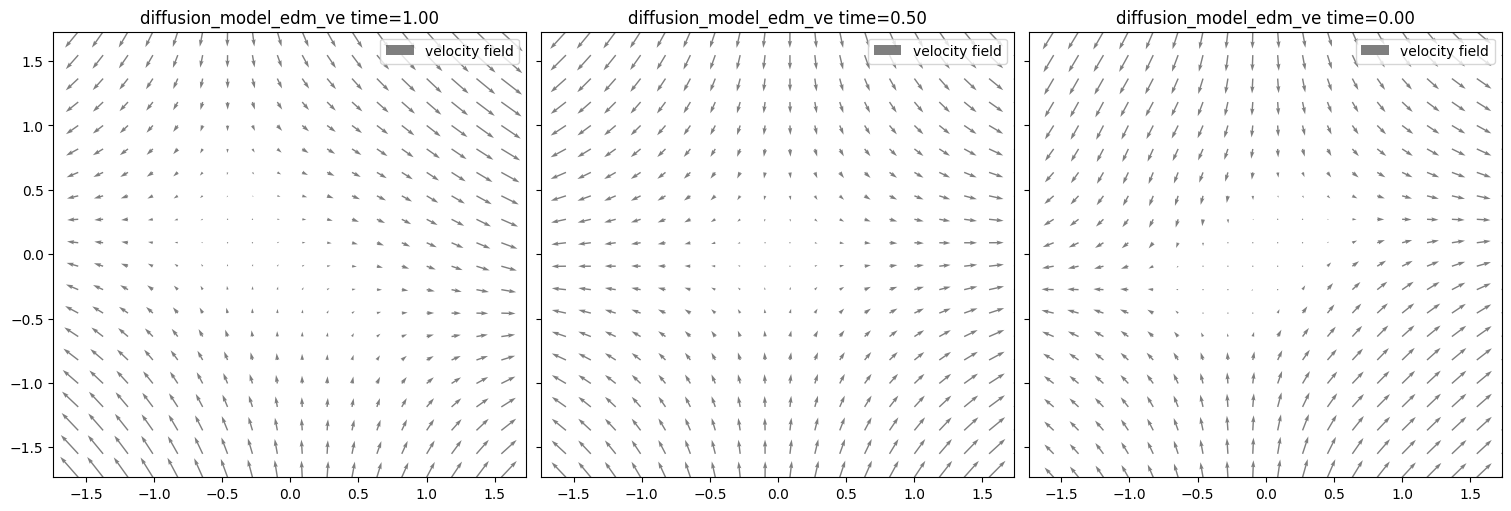

/Users/jonas.arruda/PyCharm Projects/diffusion-experiments/.venv/lib/python3.12/site-packages/keras/src/backend/jax/core.py:267: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


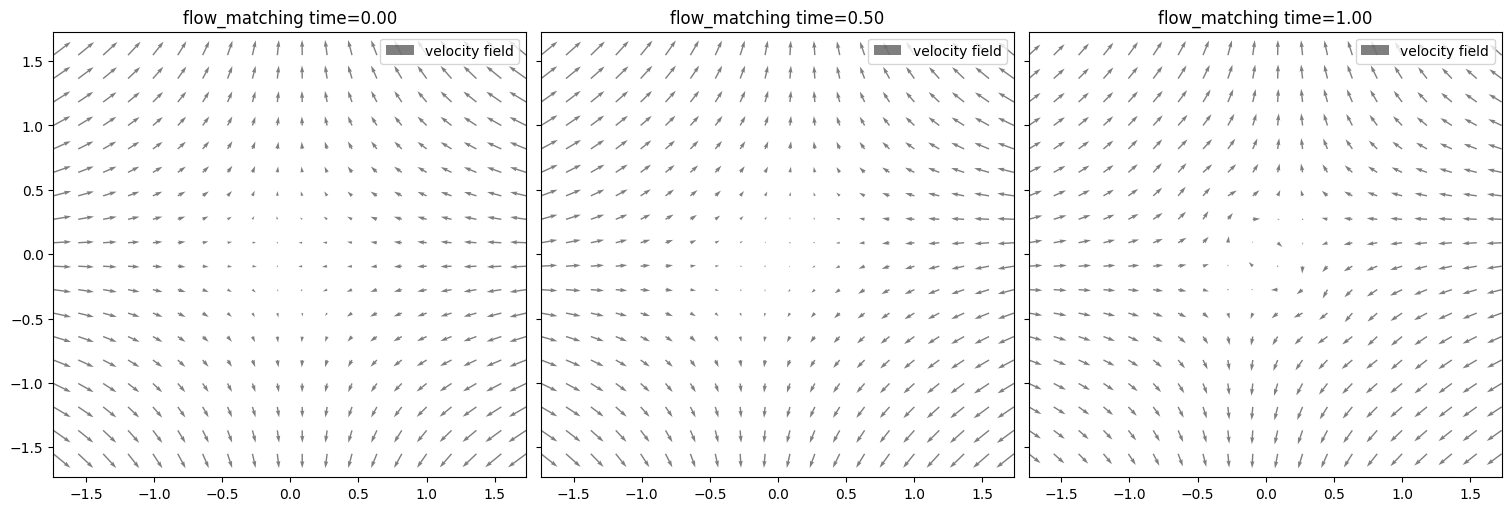

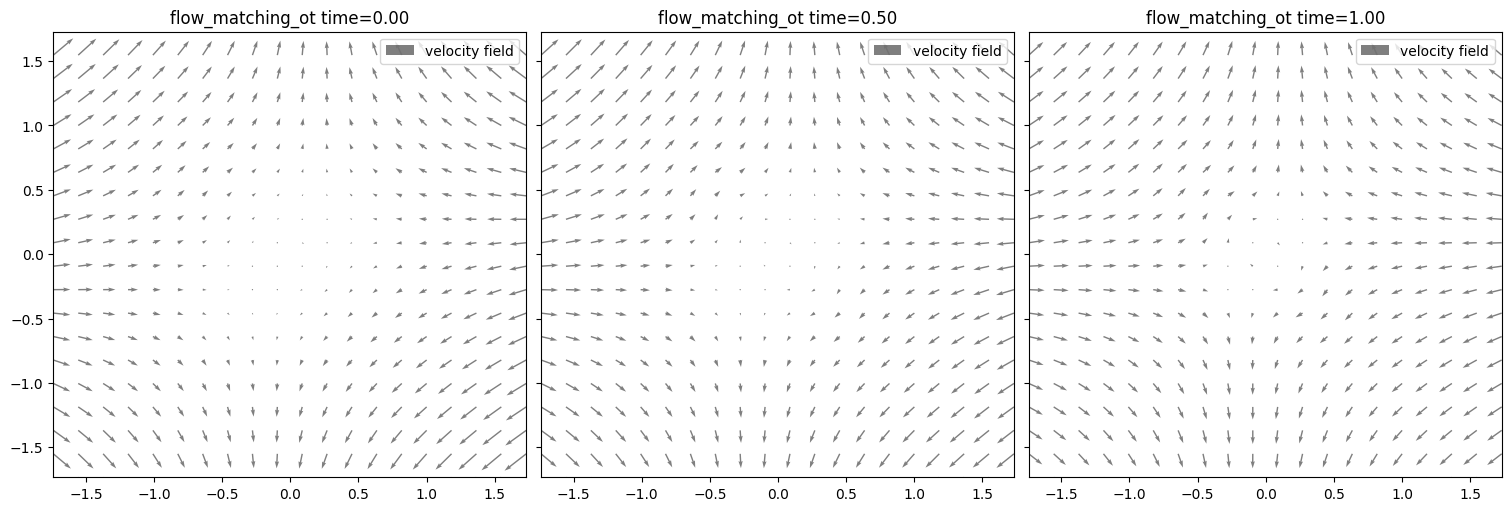

In [21]:
plot_times = [1.0, 0.5, 0.0]
for name, workflow in workflows.items():
    velocity_field_plot(
        workflow,
        conditions=conditions,
        times=plot_times if name.split('_')[0] == 'diffusion' else plot_times[::-1],
        stochastic_solver=False,
        name=name
    )

# Visualizing the Schedules

In [22]:
from bayesflow.networks.diffusion_model.schedules import EDMNoiseSchedule, CosineNoiseSchedule, NoiseSchedule

In [23]:
class FlowMatching(NoiseSchedule):
    def __init__(self, name="Flow Matching Schedule"):
        super().__init__(name=name, variance_type="preserving", weighting=None)

    def get_log_snr(self, t, training):
        """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
        return 2 * keras.ops.log((1-t)/t)

    def get_alpha_sigma(self, t):
        alpha_t = 1 - t
        sigma_t = 1 - alpha_t
        return alpha_t, sigma_t

    def get_t_from_log_snr(self, log_snr_t, training: bool):
        raise NotImplementedError

    def derivative_log_snr(self, log_snr_t, training):
        raise NotImplementedError

    def get_weights_for_snr(self, log_snr_t):
        return 1 + keras.ops.exp(-log_snr_t) + 2*keras.ops.exp(-log_snr_t / 2)

In [24]:
def sample_powerlaw(alpha, size=1):
    """
    Sample from distribution with CDF p(t) ∝ t^(1/(1+α)) on [0,1]

    Parameters:
    -----------
    alpha : float
        Shape parameter. α = 0 gives uniform distribution
    size : int or tuple
        Number of samples to generate

    Returns:
    --------
    samples : ndarray
        Samples from the distribution
    """
    # Generate uniform random samples
    u = np.random.uniform(0, 1, size)

    # Since p(t) ∝ t^(1/(1+α)) is the CDF, we need the inverse
    # Normalized CDF: F(t) = t^(1/(1+α))
    # Inverse CDF: F^(-1)(u) = u^(1+α)
    return 1 - u ** (1 + alpha)

In [25]:
edm = EDMNoiseSchedule()
edm_ve = EDMNoiseSchedule(variance_type='exploding')
cosine = CosineNoiseSchedule(weighting=None)
edm.name = "EDM Schedule"# VP"
edm_ve.name = "EDM Schedule VE"
cosine.name = "Cosine Schedule"
fm = FlowMatching()
fm_pl = FlowMatching(r"Flow Matching Schedule $\rho=-0.6$")

time = keras.ops.linspace(0.0, 1, 10000)
# gebhard: t^(1/4) sim U(0,1)
#fm_time = (1-time) ** 4
# power law with alpha=-0.6
fm_time = sample_powerlaw(alpha=-0.6, size=time.shape[0])
fm_time = np.sort(fm_time)
fm_time = keras.ops.convert_to_tensor(fm_time)
colors = [
    "#0072B2",  # blue (EDM)
    "#E69F00",  # orange (Cosine)
    "#009E73",  # green (Flow Matching)
    "#D55E00",  # red (Flow Matching power law)
]
schedules = [edm, #edm_ve,
             cosine, fm, fm_pl]

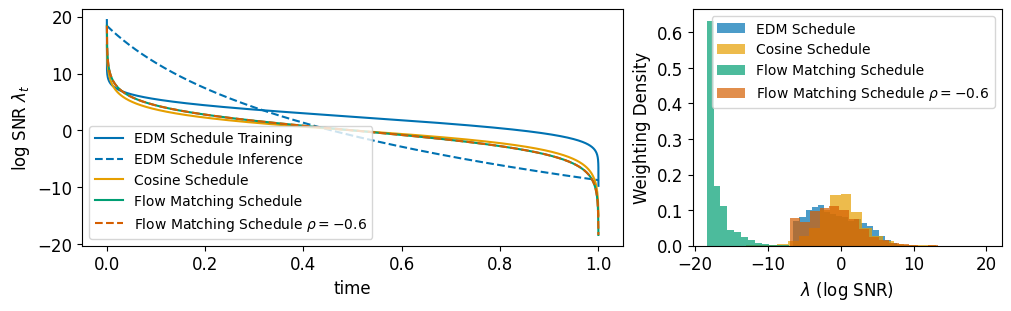

In [26]:
fig, axis = plt.subplots(1, 2, figsize=(10,3), layout='constrained', gridspec_kw={'width_ratios': [1.75, 1]})
ax = axis[0]
for i, schedule in enumerate(schedules):
    training_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=True))
    inference_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=False))

    if (training_schedule != inference_schedule).all():
        ax.plot(time, training_schedule, label=f"{schedule.name} Training", color=colors[i])
        ax.plot(time, inference_schedule, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
    else:
        if schedule.name == r'Flow Matching Schedule $\rho=-0.6$':
            ax.plot(time, training_schedule, label=f"{schedule.name}", color=colors[i], linestyle="--")
        else:
            ax.plot(time, training_schedule, label=f"{schedule.name}", color=colors[i])
ax.legend(loc="lower left")
ax.set_ylabel(r"log SNR $\lambda_t$")
ax.set_xlabel("time")
# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('schedules.pdf', bbox_inches='tight')
#plt.show()

#fig, ax = plt.subplots(ncols=1, figsize=(4,3), layout='constrained', sharey=True)
ax = axis[1]
for i, schedule in enumerate(schedules):
    if schedule.name == r'Flow Matching Schedule $\rho=-0.6$':
        training_schedule = schedule.get_log_snr(fm_time[1:-1], training=True)
    else:
        training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    training_weights = keras.ops.convert_to_numpy(schedule.get_weights_for_snr(training_schedule))
    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax.hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

ax.set_xlabel(r"$\lambda$ (log SNR)")
ax.set_ylabel("Weighting Density")
#ax.set_xlim([-8.5, 12])
#ax.set_ylim([-0, 0.6])
ax.legend(labels=[s.name for s in schedules], loc="upper right")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.savefig('schedules.pdf', bbox_inches='tight')
plt.show()

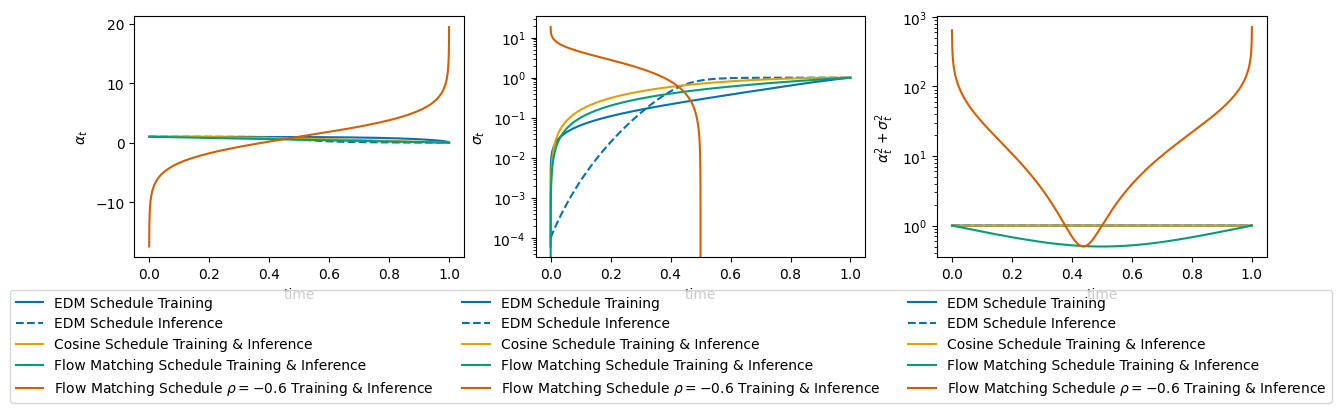

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3), layout='constrained') #, sharey=True)
for i, schedule in enumerate(schedules):
    if schedule.name == 'Flow Matching Schedule':
        alpha_t_training, sigma_t_training = schedule.get_alpha_sigma(time)
        alpha_t_inference, sigma_t_inference = alpha_t_training, sigma_t_training
    else:
        training_schedule = schedule.get_log_snr(time, training=True)
        inference_schedule = schedule.get_log_snr(time, training=False)
        alpha_t_training, sigma_t_training = schedule.get_alpha_sigma(training_schedule)
        alpha_t_inference, sigma_t_inference = schedule.get_alpha_sigma(inference_schedule)
    alpha_t_training = keras.ops.convert_to_numpy(alpha_t_training)
    sigma_t_training = keras.ops.convert_to_numpy(sigma_t_training)
    alpha_t_inference = keras.ops.convert_to_numpy(alpha_t_inference)
    sigma_t_inference = keras.ops.convert_to_numpy(sigma_t_inference)

    if (training_schedule != inference_schedule).all():
        ax[0].plot(time, alpha_t_training, label=f"{schedule.name} Training", color=colors[i])
        ax[0].plot(time, alpha_t_inference, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
        ax[1].plot(time, sigma_t_training, label=f"{schedule.name} Training", color=colors[i])
        ax[1].plot(time, sigma_t_inference, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
        ax[2].plot(time, alpha_t_training**2+sigma_t_training**2, label=f"{schedule.name} Training", color=colors[i])
        ax[2].plot(time, alpha_t_inference**2+sigma_t_inference**2, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
    else:
        ax[0].plot(time, alpha_t_training, label=f"{schedule.name} Training & Inference", color=colors[i])
        ax[1].plot(time, sigma_t_training, label=f"{schedule.name} Training & Inference", color=colors[i])
        ax[2].plot(time, alpha_t_training**2+sigma_t_training**2, label=f"{schedule.name} Training & Inference", color=colors[i])
for a in ax:
    a.set_xlabel("time")
ax[0].set_ylabel(r"$\alpha_t$")
ax[1].set_ylabel(r"$\sigma_t$")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[2].set_ylabel(r"$\alpha_t^2+\sigma_t^2$")
fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.35))
plt.show()

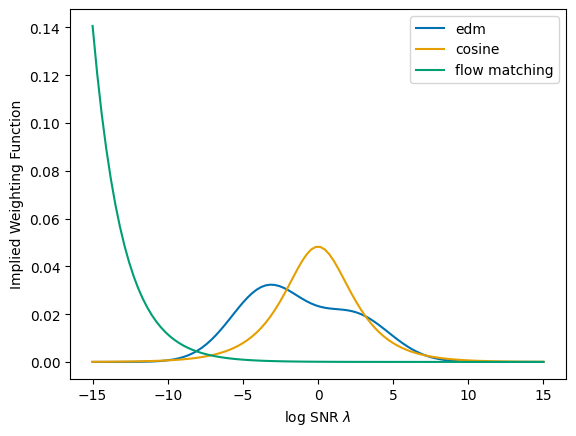

In [28]:
# theoretical densities from Kingma Paper
lambda_t = np.linspace(-15, 15, 100)
edm_w = norm.pdf(lambda_t, loc=2.4, scale=2.4) * (np.exp(-lambda_t) + 1**2)
cosine_w = sech(lambda_t / 2)
fm_w =  np.exp(-lambda_t/2)

plt.plot(lambda_t, edm_w / sum(edm_w), label='edm', color=colors[0])
plt.plot(lambda_t, cosine_w / sum(cosine_w), label='cosine', color=colors[1])
plt.plot(lambda_t, fm_w / sum(fm_w), label='flow matching', color=colors[2])
plt.xlabel(r"log SNR $\lambda$")
plt.ylabel("Implied Weighting Function")
plt.legend()
plt.show()

# Variance Types

- Variance preserving (VP): $\alpha_t = \sqrt{1 - \sigma_t^2}$. The total variance remains constant over $t$. This setting maintains a balance between signal and noise at each step.
- Variance exploding (VE): $\alpha_t = 1$ with $\sigma_t$ growing large. Here the signal is constant but the noise variance increases.
- Sub-variance preserving (sub-VP)}: $\alpha_t = \sqrt{1 - \sigma_t}$.
- Flow matching: $\alpha_t = 1 - \sigma_t$.

In [29]:
t = np.linspace(1,0, 1000)

vp_sigma_t = t
vp_alpha_t = np.sqrt(1 - vp_sigma_t ** 2)

ve_sigma_t = t
ve_alpha_t = np.ones_like(ve_sigma_t)

sub_vp_sigma_t = t
sub_vp_alpha_t = np.sqrt(1 - sub_vp_sigma_t)

fm_sigma_t = t
fm_alpha_t = 1 - t

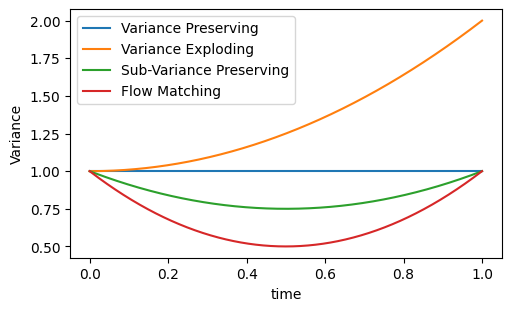

In [30]:
fig = plt.figure(figsize=(5,3), layout='constrained')
plt.plot(t, vp_sigma_t**2+vp_alpha_t**2, label='Variance Preserving')
plt.plot(t, ve_sigma_t**2+ve_alpha_t**2, label='Variance Exploding')
plt.plot(t, sub_vp_sigma_t**2+sub_vp_alpha_t**2, label='Sub-Variance Preserving')
plt.plot(t, fm_sigma_t**2+fm_alpha_t**2, label='Flow Matching')
plt.ylabel('Variance')
plt.xlabel('time')
plt.legend()
plt.show()